In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_classif
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Dropout, InputLayer

%matplotlib inline

In [ ]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
train_data, test_data = tfds.load(name='imdb_reviews', split=['train', 'test'], batch_size=-1, as_supervised=True)
TRAIN_TEXTS, TRAIN_LABELS = tfds.as_numpy(train_data)
TEST_TEXTS, TEST_LABELS = tfds.as_numpy(test_data)

### Data Exploration


**Number of samples**: Total number of examples you have in the data.

**Number of classes**: Total number of topics or categories in the data.

**Number of samples per class**: Number of samples per class (topic/category). In a balanced dataset, all classes will have a similar number of samples; in an imbalanced dataset, the number of samples in each class will vary widely.

**Number of words per sample**: Median number of words in one sample.

In [ ]:
from pprint import pprint

def get_samples_per_class(training_labels):
  classes, counts = np.unique(training_labels, return_counts=True)
  return {classes : counts for classes, counts in zip(classes, counts)}

def get_num_per_sample(train_examples):
  num_words = [len(s.split()) for s in train_examples]
  return np.median(num_words)

samples_num_train = len(TRAIN_TEXTS)
samples_num_test = len(TEST_TEXTS)
median = get_num_per_sample(TRAIN_TEXTS)

print(f"Number of training examples {samples_num_train}")
print(f"Number of test examples {samples_num_test}")
print(f"Number of words per sample {median}")
pprint(get_samples_per_class(TRAIN_LABELS))

Number of training examples 25000
Number of test examples 25000
Number of words per sample 174.0
{0: 12500, 1: 12500}


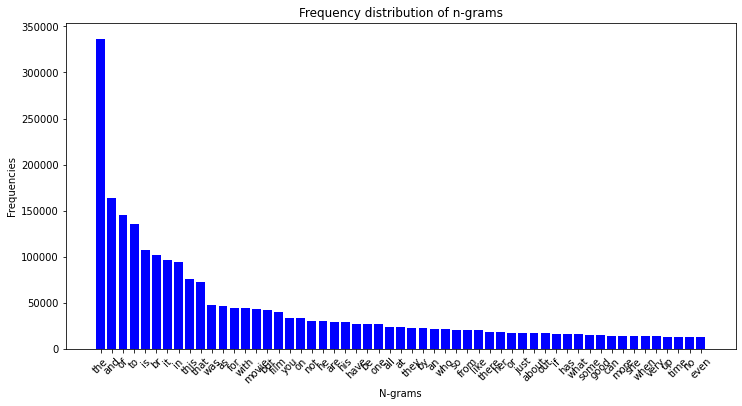

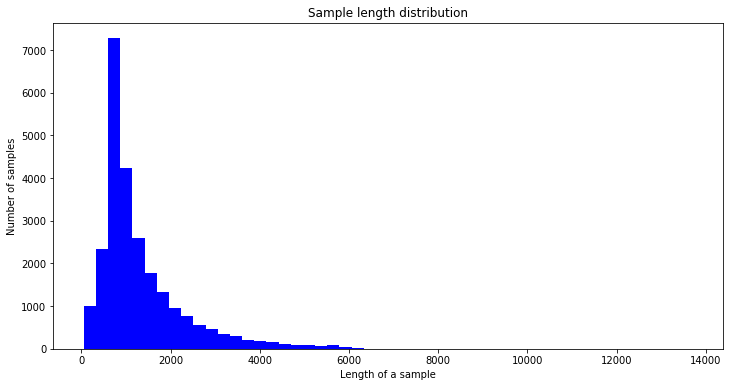

In [ ]:
def plot_frequency_distribution_for_ngrams(texts, ngram_range=(1,1), num_ngrams=55, figsize = (12, 6)):
  """
    arguments:
    texts: iterable, text to be processed
    ngram_range: tuple, The lower and upper boundary of the range of n-values for different n-grams
    num_ngrams: int, number of n-grams to be showen in the graph
    figsize: tuple, figure size width-hieght
  """
  kwargs = {'strip_accents': 'unicode', #Remove accents and perform other character normalization
            'analyzer' : 'word', #features should be made of words
            'decode_error' : 'replace', #what to do if unsupported characters is faced
            'ngram_range' : ngram_range,
            'dtype' : 'int32'} #Type of the matrix returned by fit_transform() or transform().

  countvec = CountVectorizer(**kwargs)

    #returns document term matrix; which encode every word as a column
    #and every example/doc/sentence as a row, with values are the count
    #of word frequency in each example.
  vectorized_text = countvec.fit_transform(texts) #csr_matrix

  all_ngrams = countvec.get_feature_names_out() #returns ndarray of str objects of Transformed feature names.
  num_ngrams = min(num_ngrams, len(all_ngrams))

  all_counts = vectorized_text.sum(axis=0).tolist()[0]
    #sorted function sorts according to the fist value in the tuple
  all_counts, all_ngrams = zip(*sorted(zip(all_counts, all_ngrams), reverse=True))
  top_counts = list(all_counts)[:num_ngrams]
  top_ngrams = list(all_ngrams)[:num_ngrams]

  x = np.arange(num_ngrams)
  plt.figure(figsize=figsize)
  plt.bar(x, top_counts, width=0.8, color='b')
  plt.xlabel('N-grams')
  plt.ylabel('Frequencies')
  plt.title('Frequency distribution of n-grams')
  plt.xticks(x, top_ngrams, rotation=45)
  plt.show()
  return None

def plot_sample_length_dist(texts, figsize=(12, 6), bars=50):
  """
  arguments:
  sample_text: list, text examples
  """
  lengths = [len(s) for s in texts]
  plt.figure(figsize=figsize)
  plt.hist(lengths, bars, color='b')
  plt.xlabel('Length of a sample')
  plt.ylabel('Number of samples')
  plt.title('Sample length distribution')
  plt.show()
  return None


plot_frequency_distribution_for_ngrams(TRAIN_TEXTS)
plot_sample_length_dist(TRAIN_TEXTS)

# Data Preprocessing

## Vectorization

**Bag of words**:
it is an approach that discards a lot of information about word order and grammar. This representation is used in conjunction with models that don’t take ordering into account, such as logistic regression, multi-layer perceptrons, gradient boosting machines, support vector machines.

**TF-IDF**:
stands for: term frequency-Inverse document frequency. it is given by $tf * idf$ foumulas.


$\begin{align}
tf = \frac{number\ of\ repetitive\ words\ sentence}{number\ of\ words\ in\ a\ sentence}
\end{align}$


$\begin{align}
idf = log(\frac{number\ of\ sentences}{number\ of\ sentences\ containing\ the\ word})
\end{align}$

## Feature Selection

When we convert all of the texts in a dataset into word uni+bigram tokens, we may end up with tens of thousands of tokens. Not all of these tokens/features contribute to label prediction. So we can drop certain tokens, for instance those that occur extremely rarely across the dataset. We can also measure feature importance (how much each token contributes to label predictions), and only include the most informative tokens.

There are a lot of statistical functions that does that but I chose analysis of variance (ANOVA F-value).

intuitively it calulates the $\frac{distance\ between\ classes}{compaciness\ of\ classes}$

for more deeper dive into the calculation refer to this two useful links [1](https://datascience.stackexchange.com/questions/74465/how-to-understand-anova-f-for-feature-selection-in-python-sklearn-selectkbest-w)
[2](https://www.youtube.com/watch?v=NF5_btOaCig)

In [ ]:
NGRAM_RANGE = (1, 2)
TOP_K = 20000
TOKEN_MODE = 'word'
MIN_DOCUMENT_FREQUENCY = 2

def ngram_vectorize(train_texts, train_labels, val_texts):
  """
  Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

  Returns
        x_train, x_val: vectorized training and validation texts
  """
  kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY, #ignore words that have lower frequency
    }
  vectorizer = TfidfVectorizer(**kwargs)
  x_train = vectorizer.fit_transform(train_texts)
  x_val = vectorizer.transform(val_texts)

  # Select top 'k' of the vectorized features.
  selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
  selector.fit(x_train, train_labels)
  x_train = selector.transform(x_train).astype('float32')
  x_val = selector.transform(x_val).astype('float32')
  return x_train, x_val

# Build and Train model

In [ ]:
def get_last_layer_spec(num_classes):

  if num_classes == 2:
    activation = 'sigmoid'
    units = 1
  else:
    activation = 'softmax'
    units = num_classes

  return units, activation

def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
  """Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.

    # Returns
        An MLP model instance.
    """
  last_units, last_activation = get_last_layer_spec(num_classes)
  model = models.Sequential()
  model.add(InputLayer(input_shape=input_shape, sparse=True))

  for _ in range(layers - 1):
    model.add(Dense(units=units, activation='relu'))
    model.add(Dropout(rate=dropout_rate))

  model.add(Dense(units=last_units, activation=last_activation))

  return model

In [ ]:
def train_model(data, learning_rate=1e-5, epochs=100, batch_size=64, layers= 4, units=128, dropout_rate=0.2, num_classes=2):
  """Trains mlp model on the given dataset.

    Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.

    """
    #getting the data
  (train_texts, train_labels) , (test_texts, test_labels) = data
  train_labels = train_labels.astype('float32')
  test_labels = test_labels.astype('float32')
    #vectorize the data
  x_train, x_val = ngram_vectorize(train_texts, train_labels, test_texts)

    #create the model

  model = mlp_model(layers =layers, units=units, dropout_rate=dropout_rate, input_shape=x_train.shape[1:], num_classes=num_classes)

  if num_classes == 2:
    loss = "binary_crossentropy"
  else:
    loss = "sparse_categorical_crossentropy"

  optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
  model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in three consecutive tries, stop training.
  callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)]

  history = model.fit(x_train, train_labels,
                      epochs=epochs, callbacks=callbacks,
                      validation_data=(x_val, test_labels),
                      verbose=2, batch_size=batch_size)

  history = history.history
  print('Validation accuracy: {acc}, loss: {loss}'.format(
          acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

  return history['val_acc'], history['val_loss']

In [ ]:
data = ((TRAIN_TEXTS, TRAIN_LABELS), (TEST_TEXTS, TEST_LABELS))
val_acc, val_loss = train_model(data)

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:2029: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(


Epoch 1/100


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_11/dense_22/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_11/dense_22/embedding_lookup_sparse/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_11/dense_22/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


391/391 - 4s - loss: 0.6925 - acc: 0.5098 - val_loss: 0.6910 - val_acc: 0.5151 - 4s/epoch - 10ms/step
Epoch 2/100
391/391 - 3s - loss: 0.6852 - acc: 0.5992 - val_loss: 0.6754 - val_acc: 0.6607 - 3s/epoch - 8ms/step
Epoch 3/100
391/391 - 3s - loss: 0.6561 - acc: 0.7611 - val_loss: 0.6309 - val_acc: 0.7813 - 3s/epoch - 8ms/step
Epoch 4/100
391/391 - 3s - loss: 0.5940 - acc: 0.8473 - val_loss: 0.5569 - val_acc: 0.8323 - 3s/epoch - 8ms/step
Epoch 5/100
391/391 - 3s - loss: 0.5072 - acc: 0.8834 - val_loss: 0.4722 - val_acc: 0.8674 - 3s/epoch - 8ms/step
Epoch 6/100
391/391 - 3s - loss: 0.4197 - acc: 0.9000 - val_loss: 0.3986 - val_acc: 0.8816 - 3s/epoch - 8ms/step
Epoch 7/100
391/391 - 3s - loss: 0.3447 - acc: 0.9141 - val_loss: 0.3420 - val_acc: 0.8907 - 3s/epoch - 8ms/step
Epoch 8/100
391/391 - 3s - loss: 0.2906 - acc: 0.9192 - val_loss: 0.3044 - val_acc: 0.8945 - 3s/epoch - 8ms/step
Epoch 9/100
391/391 - 3s - loss: 0.2519 - acc: 0.9229 - val_loss: 0.2792 - val_acc: 0.8974 - 3s/epoch - 8ms

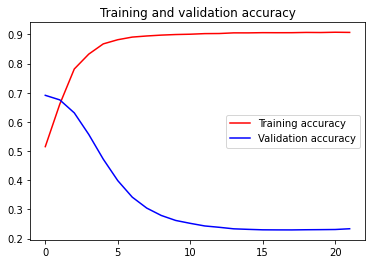

<Figure size 432x288 with 0 Axes>

In [ ]:
epochs = range(len(val_acc))

plt.plot(epochs, val_acc, 'r', label='validation accuracy')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('validation loass and accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()